/Users/adigopal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Single-case launch C3 (MSL window) = 11.014765 km^2/s^2


/var/folders/r7/0d_8lt7n2clcwr7lf8yptqtc0000gn/T/ipykernel_46678/3219916211.py:189: DeprecationWarning:

Specifying min_anomaly and max_anomaly in method `sample` is deprecated and will be removed in a future release, use `Orbit.to_ephem(strategy=TrueAnomalyBounds(min_nu=..., max_nu=...))` instead



[-29.29137306  14.53222131   5.41641774]
[ 17.61560686 -10.99849913  -4.2080014 ]
||v1 - v1_ref|| [km/s] = 5.329394851768234e-09
||v2 - v2_ref|| [km/s] = 5.01062428789693e-09


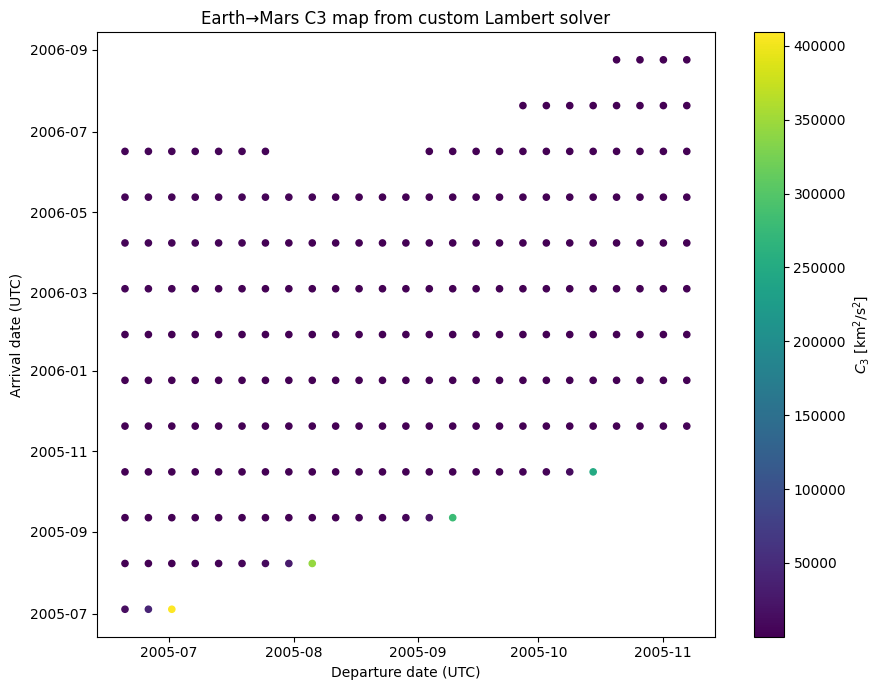

PorkchopPlotter unavailable or failed; skip internal check: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


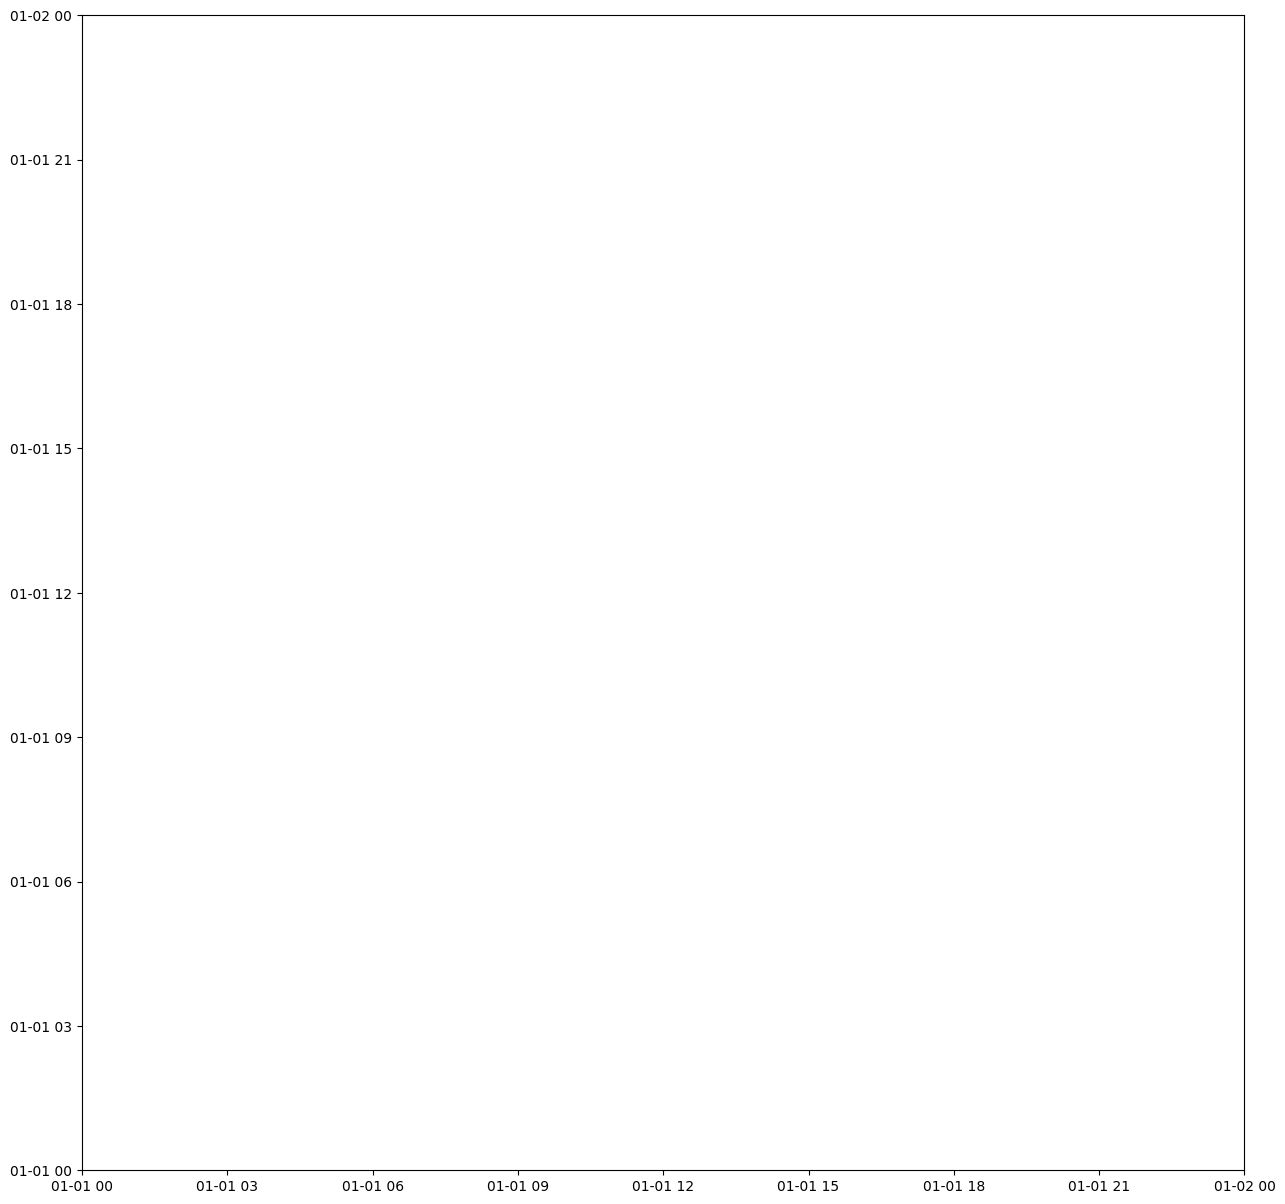

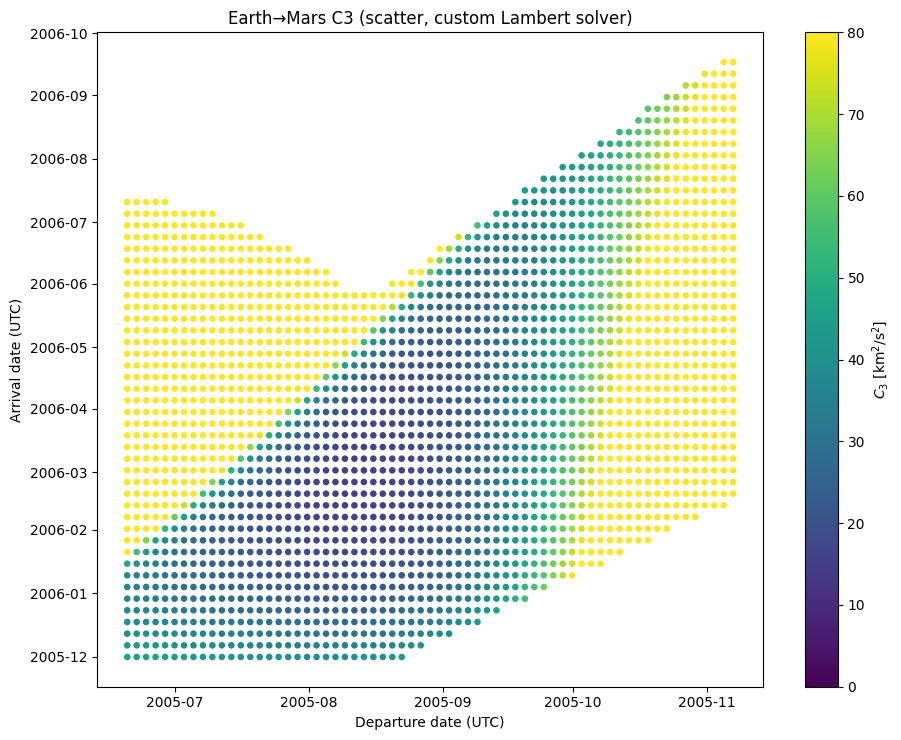

PorkchopPlotter unavailable or failed; skip internal check: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''


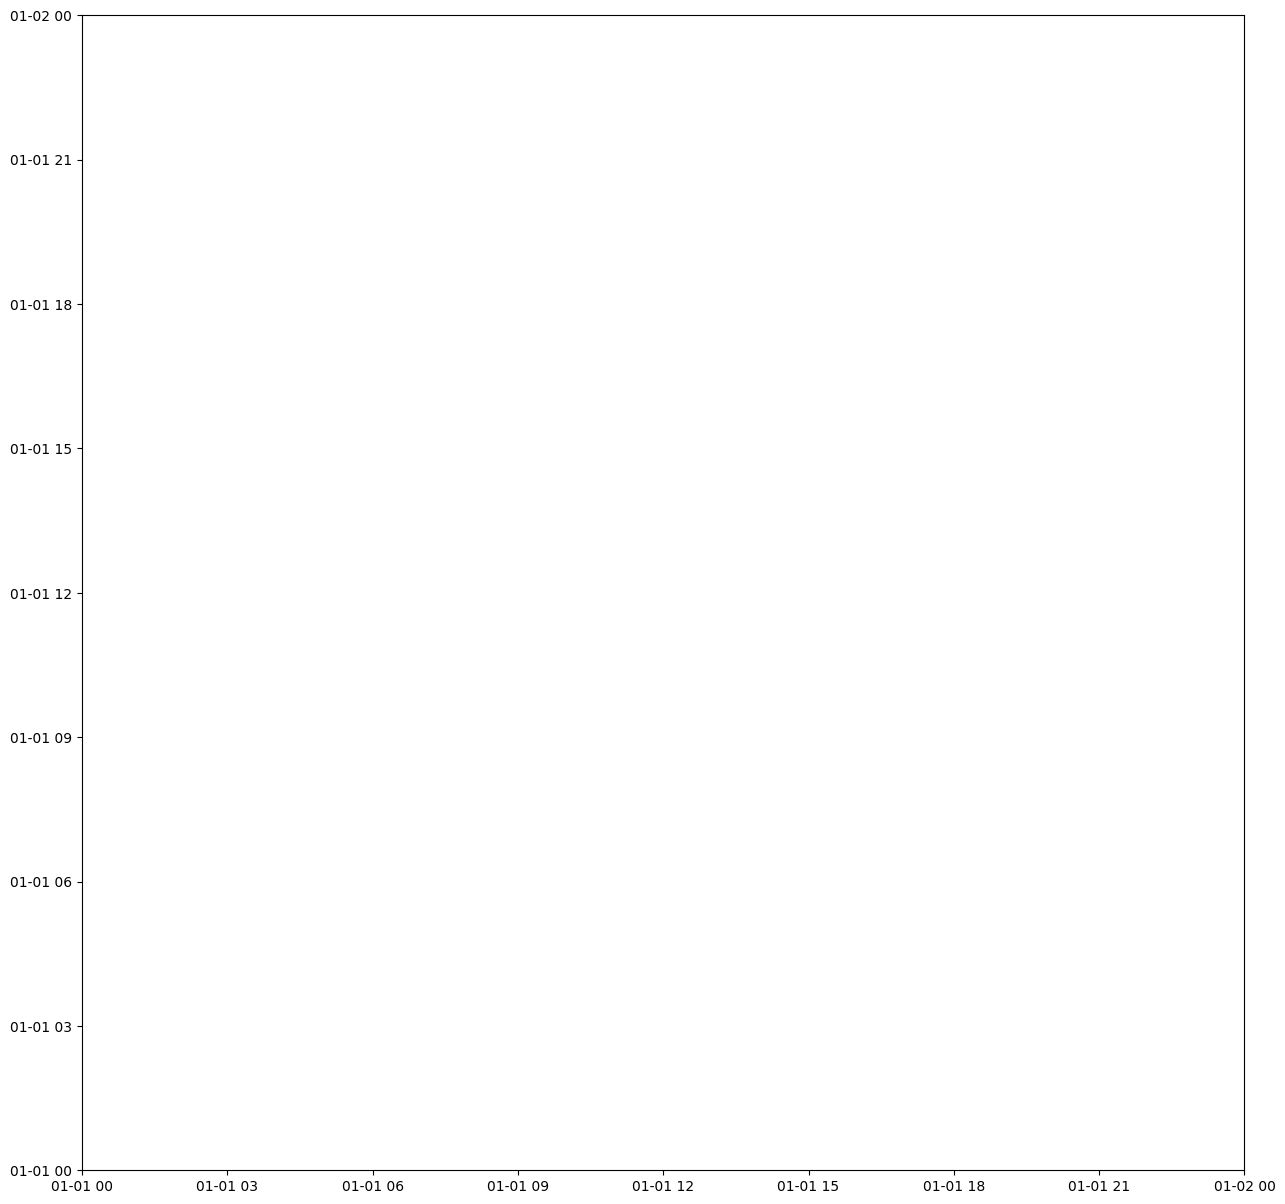

In [1]:

from astropy import units as u
from astropy import time
from astropy.coordinates import solar_system_ephemeris

import numpy as np

from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range

# Stumpff functions + norm from poliastro math helpers
from poliastro._math.special import stumpff_c2 as cee, stumpff_c3 as ess
from poliastro._math.linalg import norm

# Plotting (3D + matplotlib)
try:
    # Try modern plotly backend location
    from poliastro.plotting.plotly import OrbitPlotter3D
except Exception:
    # Fallback (legacy)
    from poliastro.plotting import OrbitPlotter3D

from matplotlib import pyplot as plt

# Lambert wrapper: prepares inputs, calls solver, then builds a two-impulse Maneuver
def lambert_compute(orbit_i, orbit_f):
    k = orbit_i.attractor.k
    r_i = orbit_i.r
    r_f = orbit_f.r

    tof = orbit_f.epoch - orbit_i.epoch  # Time of flight
    if tof.to_value(u.s) < 0:
        raise ValueError("Error: Negative time of flight.")

    kms = u.km / u.s
    k_ = k.to_value(u.km**3 / u.s**2)
    r0_ = r_i.to_value(u.km)
    r_ = r_f.to_value(u.km)
    tof_ = tof.to_value(u.s)

    # Solve Lambert (single revolution, prograde, lowpath)
    v1, v2 = lambert_calculate(
        k_, r0_, r_, tof_, M=0, prograde=True, lowpath=True, numiter=200, rtol=1e-8
    )

    dv_a = v1 << kms  # heliocentric v at departure from Lambert
    dv_b = v2 << kms  # heliocentric v at arrival from Lambert

    # Subtract/add planetary velocities to get the two impulses in the Sun frame
    return Maneuver(
        (0 * u.s, (dv_a - orbit_i.v).decompose()),
        (tof.to(u.s), (orbit_f.v - dv_b).decompose()),
    )

# Universal-variable Lambert solver (single-rev), with bisection on z
def lambert_calculate(mu, r1, r2, tof, M, prograde, lowpath, numiter, rtol):
    """
    Universal-variables Lambert solver (prograde/retrograde via t_m).
    Inputs:
      mu [km^3/s^2], r1,r2 [km 3-vectors], tof [s]
    Returns:
      v1, v2 [km/s 3-vectors]
    """
    r1 = np.array(r1, dtype=float)
    r2 = np.array(r2, dtype=float)

    r1n = norm(r1)
    r2n = norm(r2)
    if r1n == 0 or r2n == 0:
        raise ValueError("Zero vector passed for r1 or r2")

    # Geometry
    cos_theta = (r1 @ r2) / (r1n * r2n)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    t_m = 1.0 if prograde else -1.0
    A = t_m * np.sqrt(r1n * r2n * (1.0 + cos_theta))
    if np.isclose(A, 0.0, atol=1e-14):
        raise RuntimeError("Error: Cannot compute orbit, phase angle is 180 degrees.")

    # Root-finding bounds for z (universal variable)
    z = 0.0
    z_low = -np.pi**2
    z_up = np.pi**2

    # Helpers
    def y_of_z(zz):
        C = cee(zz)
        S = ess(zz)
        sc = np.sqrt(C)  # for z->0, C->1/2 so sc is safe
        return r1n + r2n + A * ((zz * S - 1.0) / sc)

    def tof_of_z(zz):
        y = y_of_z(zz)
        if y <= 0:
            return np.inf
        C = cee(zz)
        S = ess(zz)
        chi = np.sqrt(y / C)
        return (chi**3 * S + A * np.sqrt(y)) / np.sqrt(mu)

    # Ensure y>0 when needed
    if A > 0.0:
        y = y_of_z(z)
        safety_iter = 0
        while y <= 0.0 and safety_iter < 100:
            z = z + 0.1 if z >= 0 else 0.1
            y = y_of_z(z)
            safety_iter += 1
        if y <= 0.0:
            z = 0.1
            y = y_of_z(z)

    # Bisection on z
    it = 0
    dt_target = float(tof)
    while it < max(100, numiter):
        y = y_of_z(z)
        if y <= 0.0:
            z_low = z
            z = 0.5 * (z_low + z_up)
            it += 1
            continue

        dt_new = tof_of_z(z)
        if not np.isinf(dt_new) and abs((dt_new - dt_target) / dt_target) < max(rtol, 1e-8):
            break

        if dt_new < dt_target:
            z_low = z
        else:
            z_up = z
        z = 0.5 * (z_low + z_up)
        it += 1
    else:
        raise RuntimeError("Error: Maximum iterations reached. No convergence.")

    # Lagrange coefficients
    C = cee(z)
    S = ess(z)
    y = y_of_z(z)
    f = 1.0 - y / r1n
    g = A * np.sqrt(y / mu)
    gdot = 1.0 - y / r2n

    # Velocities
    v1 = (r2 - f * r1) / g
    v2 = (gdot * r2 - r1) / g

    # Optional: print for quick debug
    # print("v1 =", v1, "km/s")
    # print("v2 =", v2, "km/s")

    return v1, v2

# MAIN
solar_system_ephemeris.set("jpl")

# Set departure and arrival dates (MSL case for verification)
date_launch = time.Time("2011-11-26 15:02", scale="utc").tdb
date_arrival = time.Time("2012-08-06 05:17", scale="utc").tdb

# Obtain the planetary trajectory between departure and arrival dates.
earth_traj = Ephem.from_body(Earth, time_range(date_launch, end=date_arrival))
mars_traj = Ephem.from_body(Mars, time_range(date_launch, end=date_arrival))

# Extract orbital states at departure and arrival.
earth_state = Orbit.from_ephem(Sun, earth_traj, date_launch)
mars_state = Orbit.from_ephem(Sun, mars_traj, date_arrival)

# Solve Lambert's problem and obtain the required maneuvers.
maneuver_lam = lambert_compute(earth_state, mars_state)

# Step 3: Compute launch energy requirement (C3) for the single case
dv_launch = norm(maneuver_lam.impulses[0][1].to_value(u.km / u.s))
c3_launch = dv_launch * dv_launch
print(f"Single-case launch C3 (MSL window) = {c3_launch:.6f} km^2/s^2")

# Apply the maneuvers and generate the transfer orbit.
transfer_traj, s_target = earth_state.apply_maneuver(maneuver_lam, intermediate=True)

# 3D interactive plot (Plotly)
plotter = OrbitPlotter3D()
plotter.set_attractor(Sun)
plotter.plot_ephem(earth_traj, date_launch, label="Earth at launch")
plotter.plot_ephem(mars_traj, date_arrival, label="Mars at arrival")
plotter.plot_trajectory(
    transfer_traj.sample(max_anomaly=180 * u.deg),
    color="black",
    label="Transfer orbit",
)
fig = plotter.show()
fig.show()

# Solver verification: compare to provided heliocentric velocities
v1_ref = np.array([-29.29137306, 14.53222131, 5.41641774])
v2_ref = np.array([17.61560686, -10.99849913, -4.2080014])

# Recover heliocentric v1,v2 from the Maneuver:
#   dv_departure = v1 - v_Earth_departure  => v1 = dv_departure + v_Earth_departure
#   dv_arrival   = v_Mars_arrival - v2      => v2 = v_Mars_arrival - dv_arrival
kms = u.km / u.s
v1_calc = (maneuver_lam.impulses[0][1] + earth_state.v).to_value(kms)
v2_calc = (mars_state.v - maneuver_lam.impulses[1][1]).to_value(kms)

print(v1_ref)
print(v2_ref)

print("||v1 - v1_ref|| [km/s] =", norm(v1_calc - v1_ref))
print("||v2 - v2_ref|| [km/s] =", norm(v2_calc - v2_ref))

# My own scatter "porkchop" using custom solver (labelled C3 map)
# Choose modest grids to keep runtime reasonable in a lab setting.
dep_grid = time_range("2005-06-20", end="2005-11-07", periods=25).tdb
arr_grid = time_range("2005-01-12", end="2007-04-24", periods=25).tdb

dep_pts = []
arr_pts = []
c3_vals = []

for t_dep in dep_grid:
    # Earth at departure instant
    earth_state_dep = Orbit.from_ephem(Sun, Ephem.from_body(Earth, t_dep), t_dep)
    for t_arr in arr_grid:
        if t_arr <= t_dep:
            continue  # negative/zero ToF not allowed

        # Mars at arrival instant
        mars_state_arr = Orbit.from_ephem(Sun, Ephem.from_body(Mars, t_arr), t_arr)
        try:
            man = lambert_compute(earth_state_dep, mars_state_arr)
            dv0 = norm(man.impulses[0][1].to_value(u.km / u.s))
            c3 = dv0 * dv0
            dep_pts.append(t_dep.utc.datetime)
            arr_pts.append(t_arr.utc.datetime)
            c3_vals.append(c3)
        except Exception:
            # Skip infeasible/failed cases (keeps the plot clean)
            pass

# Scatter plot: departure vs arrival colored by C3
plt.figure(figsize=(9, 7))
sc = plt.scatter(dep_pts, arr_pts, c=c3_vals, s=20)
plt.xlabel("Departure date (UTC)")
plt.ylabel("Arrival date (UTC)")
cb = plt.colorbar(sc)
cb.set_label(r"$C_3$ [$\mathrm{km^2/s^2}$]")
plt.title("Earth→Mars C3 map from custom Lambert solver")
plt.tight_layout()
plt.show()

try:
    from poliastro.plotting.porkchop import PorkchopPlotter
    pc = PorkchopPlotter(Earth, Mars, dep_grid, arr_grid)
    pc.porkchop()
    plt.show()
except Exception as e:
    print("PorkchopPlotter unavailable or failed; skip internal check:", e)


# --- Step 3: Scatter-style Porkchop (improved sampling & scaling) ---

# Date grids focussed on the 2005 launch window (cf. reference porkchop),
# and the subsequent arrival window through late 2006.
dep_grid = time_range("2005-06-20", end="2005-11-07", periods=65).tdb
arr_grid = time_range("2005-12-01", end="2006-11-30", periods=65).tdb

# Practical time-of-flight bounds (days) to avoid degenerate / huge-Δv cases
TOF_MIN = 100.0
TOF_MAX = 450.0

# Clip colour range to highlight the feasible valley
C3_CLIP_MAX = 80.0  # km^2/s^2

dep_pts, arr_pts, c3_vals = [], [], []

for t_dep in dep_grid:
    earth_state_dep = Orbit.from_ephem(Sun, Ephem.from_body(Earth, t_dep), t_dep)
    for t_arr in arr_grid:
        tof_days = (t_arr - t_dep).to_value(u.day)
        if tof_days <= 0.0 or tof_days < TOF_MIN or tof_days > TOF_MAX:
            continue

        mars_state_arr = Orbit.from_ephem(Sun, Ephem.from_body(Mars, t_arr), t_arr)
        try:
            man = lambert_compute(earth_state_dep, mars_state_arr)
            vinf = norm(man.impulses[0][1].to_value(u.km / u.s))   # launch hyperbolic excess
            c3   = float(vinf * vinf)
            # Clip to keep the colour scale informative
            c3 = float(np.clip(c3, 0.0, C3_CLIP_MAX))
            dep_pts.append(t_dep.utc.datetime)
            arr_pts.append(t_arr.utc.datetime)
            c3_vals.append(c3)
        except Exception:
            # Skip infeasible/failed cases
            pass

plt.figure(figsize=(9.5, 7.5))
sc = plt.scatter(dep_pts, arr_pts, c=c3_vals, s=14, vmin=0.0, vmax=C3_CLIP_MAX)
plt.xlabel("Departure date (UTC)")
plt.ylabel("Arrival date (UTC)")
cb = plt.colorbar(sc)
cb.set_label(r"$C_3$ [$\mathrm{km^2/s^2}$]")
plt.title("Earth→Mars C3 (scatter, custom Lambert solver)")
plt.tight_layout()
plt.show()

# (Optional) side-by-side check with Poliastro's porkchop using the same grids:
try:
    from poliastro.plotting.porkchop import PorkchopPlotter
    pc = PorkchopPlotter(Earth, Mars, dep_grid, arr_grid)
    pc.porkchop()  # contour reference (shows the two lobes clearly)
    plt.show()
except Exception as e:
    print("PorkchopPlotter unavailable or failed; skip internal check:", e)


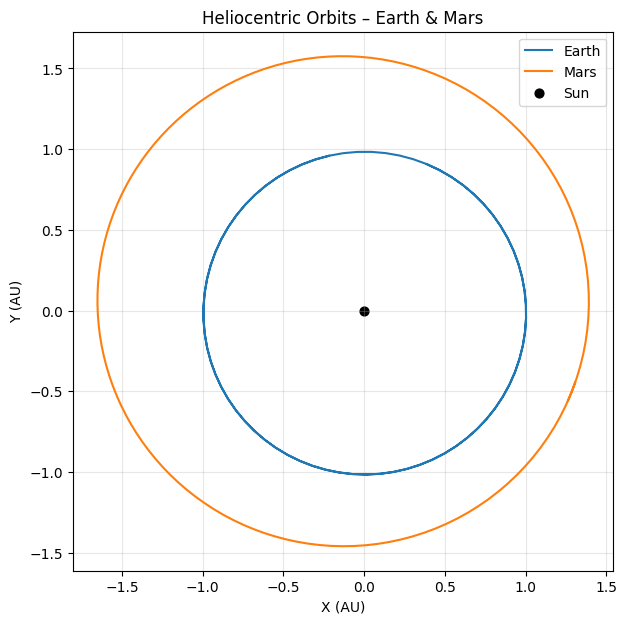

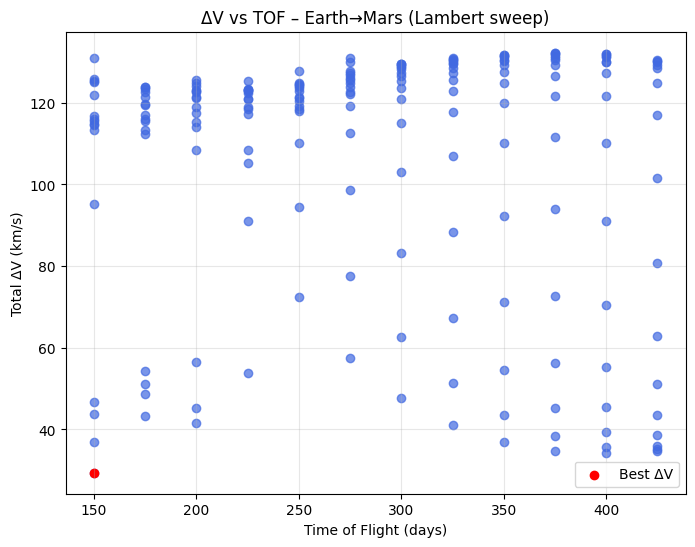

Best ΔV: 29.40 km/s, TOF = 150 days, dep = 375 days


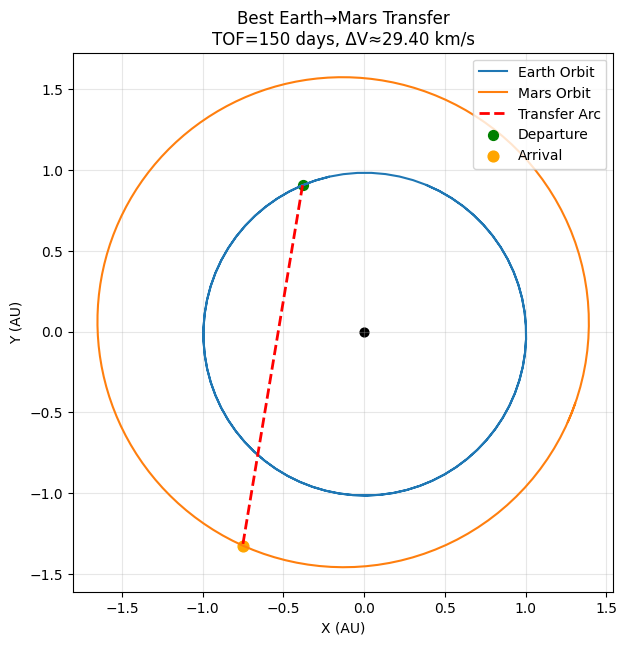

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
AU = 149597870.7  # km
MU_SUN = 1.32712440018e11  # km^3/s^2
DAY = 86400.0  # seconds

# Orbital elements (simplified J2000)
def earth_elements():
    return (1.000 * AU, 0.0167, np.deg2rad(0.0),
            np.deg2rad(0.0), np.deg2rad(102.9), 0.0)

def mars_elements():
    return (1.524 * AU, 0.0934, np.deg2rad(1.85),
            np.deg2rad(49.6), np.deg2rad(286.5), 0.0)

# Basic helpers
def rot_z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0],
                     [s,  c, 0],
                     [0,  0, 1]])

def rot_x(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[1, 0, 0],
                     [0, c, -s],
                     [0, s,  c]])

def solve_kepler(M, e, tol=1e-8):
    M = np.mod(M, 2*np.pi)
    E = M
    for _ in range(50):
        E -= (E - e*np.sin(E) - M) / (1 - e*np.cos(E))
        if abs(E - M) < tol: break
    return E

def kepler_to_state(a, e, i, raan, argp, M0, t):
    """Return (r, v) at time t [s]."""
    n = np.sqrt(MU_SUN / a**3)
    M = M0 + n*t
    E = solve_kepler(M, e)
    r_pf = np.array([a*(np.cos(E) - e),
                     a*np.sqrt(1 - e**2)*np.sin(E),
                     0])
    v_pf = np.array([-np.sin(E),
                      np.sqrt(1 - e**2)*np.cos(E),
                      0]) * np.sqrt(MU_SUN * a) / np.linalg.norm(r_pf)

    R = rot_z(raan) @ rot_x(i) @ rot_z(argp)
    return R @ r_pf, R @ v_pf

# Simple Lambert solver (single-rev, iterative)
def lambert(r1, r2, dt):
    """Basic universal variable Lambert (one-rev)"""
    r1n, r2n = np.linalg.norm(r1), np.linalg.norm(r2)
    cos_dnu = np.clip(np.dot(r1, r2)/(r1n*r2n), -1, 1)
    dnu = np.arccos(cos_dnu)
    A = np.sin(dnu)*np.sqrt(r1n*r2n/(1 - np.cos(dnu)))

    def C(z): return (1 - np.cos(np.sqrt(z)))/z if z>1e-8 else 0.5
    def S(z): return (np.sqrt(z) - np.sin(np.sqrt(z)))/(z**1.5) if z>1e-8 else 1/6

    z = 0
    for _ in range(100):
        Cz, Sz = C(z), S(z)
        y = r1n + r2n + A*(z*Sz - 1)/np.sqrt(Cz)
        if y < 0: z += 0.1; continue
        F = ((y/Cz)**1.5)*Sz + A*np.sqrt(y) - np.sqrt(MU_SUN)*dt
        if abs(F) < 1e-8: break
        dF = ((y/Cz)**1.5)*(0.5*z*(Sz/Cz - 3*Sz/Cz**2) + 1.5*Sz/Cz)
        z -= np.clip(F/dF, -1, 1)
    y = r1n + r2n + A*(z*S(z) - 1)/np.sqrt(C(z))
    f = 1 - y/r1n
    g = A*np.sqrt(y/MU_SUN)
    gdot = 1 - y/r2n
    v1 = (r2 - f*r1)/g
    v2 = (gdot*r2 - r1)/g
    return v1, v2

# Orbits & plotting
def build_orbit(elts, days=700, step=5):
    a,e,i,Om,om,M0 = elts
    ts = np.arange(0, days*DAY, step*DAY)
    pts = np.array([kepler_to_state(a,e,i,Om,om,M0,t)[0] for t in ts])
    return pts

def plot_orbits(earth, mars):
    plt.figure(figsize=(7,7))
    plt.plot(earth[:,0]/AU, earth[:,1]/AU, label="Earth")
    plt.plot(mars[:,0]/AU, mars[:,1]/AU, label="Mars")
    plt.scatter(0,0,c="k",s=40,label="Sun")
    plt.xlabel("X (AU)")
    plt.ylabel("Y (AU)")
    plt.gca().set_aspect("equal")
    plt.title("Heliocentric Orbits – Earth & Mars")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# Sweep & visualise transfers
def sweep_transfers(dep_days, tofs, e_elts, m_elts):
    results=[]
    for dep in dep_days:
        rE,vE = kepler_to_state(*e_elts, dep*DAY)
        for tof in tofs:
            rM,vM = kepler_to_state(*m_elts, (dep+tof)*DAY)
            try:
                v1,v2 = lambert(rE,rM,tof*DAY)
                dv = np.linalg.norm(v1 - vE) + np.linalg.norm(v2 - vM)
                results.append((dep,tof,dv))
            except Exception:
                continue
    return np.array(results)

def plot_dv_vs_tof(results):
    plt.figure(figsize=(8,6))
    plt.scatter(results[:,1], results[:,2], c="royalblue", alpha=0.7)
    plt.xlabel("Time of Flight (days)")
    plt.ylabel("Total ΔV (km/s)")
    plt.title("ΔV vs TOF – Earth→Mars (Lambert sweep)")
    plt.grid(alpha=0.3)
    idx = np.argmin(results[:,2])
    plt.scatter(results[idx,1], results[idx,2], c="r", label="Best ΔV")
    plt.legend()
    plt.show()
    print(f"Best ΔV: {results[idx,2]:.2f} km/s, TOF = {results[idx,1]:.0f} days, dep = {results[idx,0]:.0f} days")
    return results[idx]

# Visualise best transfer arc
def plot_transfer(e_elts, m_elts, best):
    dep, tof = best[0], best[1]
    rE,_ = kepler_to_state(*e_elts, dep*DAY)
    rM,_ = kepler_to_state(*m_elts, (dep+tof)*DAY)
    v1,_ = lambert(rE,rM,tof*DAY)

    # Approximate transfer arc as simple ellipse section (linear interpolation)
    interp = np.linspace(0,1,100)
    r_arc = np.outer(1-interp, rE) + np.outer(interp, rM)

    # Plot
    plt.figure(figsize=(7,7))
    e_pts = build_orbit(e_elts)
    m_pts = build_orbit(m_elts)
    plt.plot(e_pts[:,0]/AU, e_pts[:,1]/AU, label="Earth Orbit")
    plt.plot(m_pts[:,0]/AU, m_pts[:,1]/AU, label="Mars Orbit")
    plt.plot(r_arc[:,0]/AU, r_arc[:,1]/AU, 'r--', lw=2, label="Transfer Arc")
    plt.scatter([0],[0],c='k',s=40)
    plt.scatter(rE[0]/AU,rE[1]/AU,c='g',s=50,label="Departure")
    plt.scatter(rM[0]/AU,rM[1]/AU,c='orange',s=60,label="Arrival")
    plt.gca().set_aspect("equal")
    plt.xlabel("X (AU)")
    plt.ylabel("Y (AU)")
    plt.title(f"Best Earth→Mars Transfer\nTOF={tof:.0f} days, ΔV≈{best[2]:.2f} km/s")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

def main():
    e_elts = earth_elements()
    m_elts = mars_elements()

    # 1) Plot orbits
    earth = build_orbit(e_elts)
    mars  = build_orbit(m_elts)
    plot_orbits(earth, mars)

    # 2) Sweep departures & TOFs
    dep_days = np.arange(0, 400, 25)
    tofs = np.arange(150, 450, 25)
    results = sweep_transfers(dep_days, tofs, e_elts, m_elts)

    # 3) Plot ΔV vs TOF and identify best
    best = plot_dv_vs_tof(results)

    # 4) Plot best transfer arc on orbit plot
    plot_transfer(e_elts, m_elts, best)

if __name__ == "__main__":
    main()
